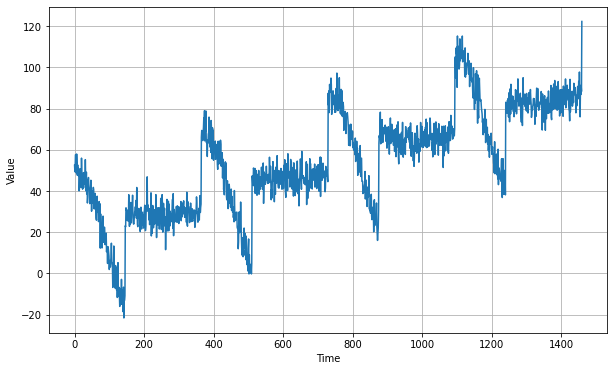

In [2]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras

def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
  
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, 
                    np.cos(season_time * 2 * np.pi), 
                    1 / np.exp(3 * season_time)
                    )
    

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period / period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
basline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Updata with noise 
series += noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [3]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [9]:
import tensorflow as tf


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Test the minimum of the learning rate

In [71]:

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)# Change Learning Rate correspond with epoch
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=0, callbacks=[lr_schedule])

print("Layer weights {}".format(l0.get_weights()))

D:\Python\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Layer weights []


Text(0.5, 0, 'Learning rate')

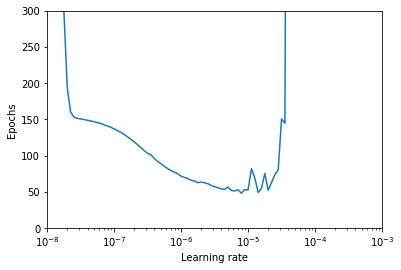

In [73]:
lrs = 1e-8 *(10**(np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.ylabel('Epochs')
plt.xlabel('Learning rate')

Set Neural Network

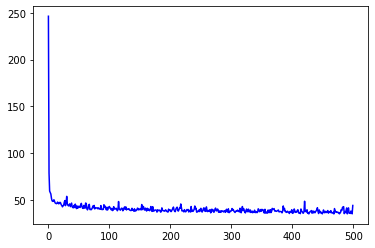

In [76]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(series, window_size, batch_size,
                           shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**
    (epoch / 20))  # Change Learning Rate correspond with epoch
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9))
history = model.fit(dataset, epochs=500, verbose=0)
loss = history.history['loss']
epochs = range(500)
plt.plot(epochs, loss, 'b', label='training loss')
plt.show()


In [78]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size:]
result = np.array(forecast)[:, 0, 0]

4.7546096


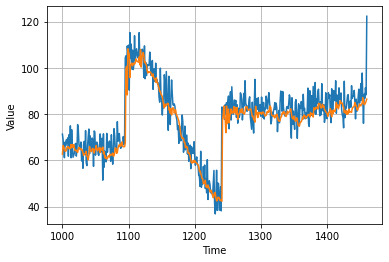

In [79]:
plot_series(time_valid, x_valid)
plot_series(time_valid, result)

print(tf.keras.metrics.mean_absolute_error(x_valid, result).numpy())